In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='9c85d5f9-adf1-4f4b-9c83-c527713bd520', project_access_token='p-485ded96efbb4539d075aaee42cdeedbe6197a99')
pc = project.project_context


# MARATONA BEHIND THE CODE 2020

## DESAFIO 4 - CompuSoluciones

### Introducción

En este desafío, CompuSoluciones usará herramientas de IBM como Watson Studio (o Cloud Pack for Data) y Watson Machine Learning para construir un modelo de Machine Learning natural capaz de predecir la probabilidad de cumplimiento de pago.

La idea esencial del Desafío 4 es crear un modelo basado en machine learning capaz de identificar el comportamiento financiero del asociado de negocio, permitiendo una probabilidad de cumplimiento o incumplimiento del crédito.

<hr>

### Instalación de Librerias

In [2]:
!pip install scikit-learn --upgrade
!pip install -U imbalanced-learn

Requirement already up-to-date: scikit-learn in /opt/conda/envs/Python36/lib/python3.6/site-packages (0.23.2)
Requirement already up-to-date: imbalanced-learn in /opt/conda/envs/Python36/lib/python3.6/site-packages (0.7.0)


In [3]:
# Si desea utilizar la biblioteca ** xgboost **, instale la versión 0.71.
#!pip install xgboost==0.71 --upgrade

In [4]:
import json
import requests
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_validate, cross_val_score, RandomizedSearchCV

### Descargando el dataset csv desde Github

In [5]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset/master/reto-4-compu-train.csv

--2020-09-04 15:50:29--  https://raw.githubusercontent.com/vanderlei-test/dataset/master/reto-4-compu-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1751735 (1.7M) [text/plain]
Saving to: ‘reto-4-compu-train.csv.1’

100%[======================================>] 1,751,735   --.-K/s   in 0.04s   

2020-09-04 15:50:29 (41.3 MB/s) - ‘reto-4-compu-train.csv.1’ saved [1751735/1751735]



In [6]:
df = pd.read_csv(r'reto-4-compu-train.csv')
df.head()

,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS,OBJETIVO
0,NaN,7.710800e+06,NaN,1.237449e+06,2.947057e+05,8.812520e+06,4.547214e+07,239671.50090,1.257907e+06,2356497.733,-6.009930e+06,-6.816681e+06,41309820.53,6.872572e+07,6298390.104,1.505762e+07,Aceptado
1,7.437098e+04,2.213116e+06,NaN,1.335531e+05,4.000109e+05,8.491851e+06,1.573254e+07,94809.20697,6.708985e+05,NaN,-7.980962e+06,-3.342452e+06,NaN,3.588274e+07,NaN,1.085156e+07,Aceptado
2,5.269987e+06,2.893119e+07,3.983352e+05,1.533061e+07,3.478673e+06,-1.393229e+07,NaN,610814.63990,1.009937e+07,1444426.243,NaN,-4.026344e+06,NaN,3.292337e+08,NaN,8.680735e+06,Sospechoso
3,9.092134e+05,1.145092e+07,9.577823e+06,1.068692e+06,1.302021e+06,1.379064e+06,NaN,NaN,2.378928e+06,1236065.779,NaN,-4.567435e+06,76310275.60,NaN,NaN,1.323267e+07,Aceptado
4,9.688669e+05,8.539206e+06,3.898283e+06,4.168733e+05,NaN,-6.297179e+05,7.620711e+06,116647.73960,1.798065e+06,3657339.603,7.702845e+05,-7.110320e+05,62901614.29,3.614260e+07,6850340.403,1.100048e+07,Aceptado


### Acerca del Dataset

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9400 entries, 0 to 9399
Data columns (total 17 columns):
EFECTIVO                     7986 non-null float64
CXC                          7968 non-null float64
INVENTARIO                   8000 non-null float64
EQ_OFICINA                   7945 non-null float64
EQ_TRANSPORTE                7988 non-null float64
TERRENOS_Y_CONSTRUCCIONES    8038 non-null float64
CXP                          7934 non-null float64
CONTRIBUCIONES_X_PAGAR       8052 non-null float64
ANTICIPOS_CTE                7976 non-null float64
CAP_SOCIAL                   8036 non-null float64
UTILIDADES_ACUMULADAS        7993 non-null float64
UTILIDAD_O_PERDIDA           8031 non-null float64
TOTAL_VENTAS                 7941 non-null float64
TOTAL_COMPRAS                7908 non-null float64
UTILIDAD_BRUTA               7971 non-null float64
TOTAL_GASTOS                 7943 non-null float64
OBJETIVO                     9400 non-null object
dtypes: float64(16), object

Las variables son todas numericas. Solo nuestra variable TARGET (Prestamo aprobado o posible incumplimiento financiero) es the tipo float.

La función describe() de abajo muestra varias estadisticas del dataset.

In [8]:
df.describe()

,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS
count,7.986000e+03,7.968000e+03,8.000000e+03,7.945000e+03,7.988000e+03,8.038000e+03,7.934000e+03,8.052000e+03,7.976000e+03,8.036000e+03,7.993000e+03,8.031000e+03,7.941000e+03,7.908000e+03,7.971000e+03,7.943000e+03
mean,1.720915e+06,1.561073e+07,1.098941e+07,4.341284e+06,1.321588e+06,6.198420e+05,2.275234e+07,4.109997e+05,2.635145e+06,3.325138e+06,4.240122e+06,-2.090086e+06,1.017051e+08,1.211510e+08,1.702067e+07,1.620236e+07
std,5.958844e+06,1.980334e+07,1.541956e+07,1.885512e+07,1.398674e+06,6.202347e+06,2.810091e+07,6.311683e+05,3.828127e+06,4.122756e+06,1.066916e+07,2.439421e+06,1.148423e+08,3.320798e+08,1.710116e+07,1.341951e+07
min,2.591455e+03,3.282261e+01,5.019700e-02,2.974216e+02,1.698222e+02,-1.577708e+07,1.276200e+01,5.638191e+03,4.495763e+00,2.334091e+00,-4.029189e+07,-8.716171e+06,7.154203e+03,1.458903e+05,2.408107e+03,3.979024e+03
25%,1.874601e+05,2.362067e+06,9.281351e+05,1.769855e+05,3.433503e+05,-3.874056e+06,3.711720e+06,1.113298e+05,3.813363e+05,5.629920e+05,-3.025772e+06,-3.824858e+06,2.303181e+07,1.214764e+07,4.836037e+06,6.104123e+06
50%,5.112329e+05,8.255125e+06,4.810330e+06,6.529255e+05,8.630635e+05,1.828932e+06,1.286143e+07,2.288855e+05,1.235872e+06,1.870131e+06,4.119952e+06,-1.629044e+06,6.309045e+07,3.473485e+07,1.181114e+07,1.272461e+07
75%,1.432613e+06,2.160462e+07,1.474278e+07,2.430901e+06,1.827559e+06,5.955197e+06,3.097250e+07,4.690705e+05,3.273238e+06,4.536913e+06,1.140550e+07,-7.368186e+03,1.378293e+08,1.007433e+08,2.352766e+07,2.260017e+07
max,3.343603e+08,2.135761e+08,1.664338e+08,5.913821e+08,1.290365e+07,9.031323e+06,2.644946e+08,1.618323e+07,4.291686e+07,4.116688e+07,4.056842e+07,1.214191e+06,1.151511e+09,1.000136e+10,1.438985e+08,9.763166e+07


<hr>

### Constantes del entorno
Se crea una semilla aleatoria para los modelos

In [9]:
semilla_aleatoria = 1234

## Extraccion de mejores caracterisitcas con Random Forest

### Entrenamiento y evaluación de un modelo de clasificación binaria


#### Transformación 1: excluir columnas del conjunto de datos

Para la creación de una transformación de datos personalizada en scikit-learn, es necesario crear una clase con los métodos transform y fit. En el método de 'transform', se ejecutará la lógica de nuestra transformación.

La siguiente celda muestra el código completo de una transformación DropColumns para eliminar columnas de un pandas DataFrame.


In [10]:
from sklearn.base import BaseEstimator, TransformerMixin


# All sklearn Transforms must have the `transform` and `fit` methods
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primero copiamos el dataframe de datos de entrada 'X'
        data = X.copy()
        # Devolvemos un nuevo dataframe de datos sin las columnas no deseadas
        return data.drop(labels=self.columns, axis='columns')

In [11]:

# Reconstruyendo un DataFrame de Pandas con el resultado de la transformación
df2 =  DropColumns(columns=[]).fit_transform(X=df)

# Ver las columnas del conjunto de datos transformado
print("\n\nColumnas del conjunto de datos después de la transformación ``DropColumns``: \n")
print(df2.columns)



Columnas del conjunto de datos después de la transformación ``DropColumns``: 

Index(['EFECTIVO', 'CXC', 'INVENTARIO', 'EQ_OFICINA', 'EQ_TRANSPORTE',
       'TERRENOS_Y_CONSTRUCCIONES', 'CXP', 'CONTRIBUCIONES_X_PAGAR',
       'ANTICIPOS_CTE', 'CAP_SOCIAL', 'UTILIDADES_ACUMULADAS',
       'UTILIDAD_O_PERDIDA', 'TOTAL_VENTAS', 'TOTAL_COMPRAS', 'UTILIDAD_BRUTA',
       'TOTAL_GASTOS', 'OBJETIVO'],
      dtype='object')


#### Transformación 3: tratamiento de datos faltantes

Para manejar los datos que faltan en nuestro conjunto de datos, ahora usaremos una transformación lista para usar de la biblioteca scikit-learn, llamada SimpleImputer.

Esta transformación permite varias estrategias para el tratamiento de datos faltantes. La documentación oficial se puede encontrar en: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

En este ejemplo, simplemente haremos cero todos los valores faltante usted puede escoger otra estrategia ;).

In [12]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [13]:
# Ver los datos faltantes del conjunto de datos antes de la primera transformación (df_data_2)
print("Valores nulos antes de la transformación SimpleImputer: \n\n{}\n".format(df2.isnull().sum(axis = 0)))
df3 = DataFrameImputer().fit_transform(df2)
# Ver los datos faltantes del conjunto de datos después de la segunda transformación (SimpleImputer) (df_data_3)
print("\n\nValores nulos en el conjunto de datos después de la transformación SimpleImputer: \n\n{}\n".format(df3.isnull().sum(axis = 0)))

Valores nulos antes de la transformación SimpleImputer: 

EFECTIVO                     1414
CXC                          1432
INVENTARIO                   1400
EQ_OFICINA                   1455
EQ_TRANSPORTE                1412
TERRENOS_Y_CONSTRUCCIONES    1362
CXP                          1466
CONTRIBUCIONES_X_PAGAR       1348
ANTICIPOS_CTE                1424
CAP_SOCIAL                   1364
UTILIDADES_ACUMULADAS        1407
UTILIDAD_O_PERDIDA           1369
TOTAL_VENTAS                 1459
TOTAL_COMPRAS                1492
UTILIDAD_BRUTA               1429
TOTAL_GASTOS                 1457
OBJETIVO                        0
dtype: int64



Valores nulos en el conjunto de datos después de la transformación SimpleImputer: 

EFECTIVO                     0
CXC                          0
INVENTARIO                   0
EQ_OFICINA                   0
EQ_TRANSPORTE                0
TERRENOS_Y_CONSTRUCCIONES    0
CXP                          0
CONTRIBUCIONES_X_PAGAR       0
ANTICIPOS_CTE   

In [14]:
class DataScaleImputer(TransformerMixin):

    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primero copiamos el dataframe de datos de entrada 'X'
        data = X.copy()
        num_features = data.columns.drop(self.columns)
        transformer = ColumnTransformer(transformers=[('scaler', StandardScaler(),num_features)])
        X_transform = transformer.fit_transform(data)
        X_imputed_df = pd.DataFrame(data = X_transform, columns = num_features.values)
        X_imputed_df[self.columns] = data[self.columns]
        return X_imputed_df

In [15]:
df4 = DataScaleImputer(columns=['OBJETIVO']).fit_transform(df3)

#### Definición de features (Variables Independientes)

En este * ejemplo * usaremos todas las columnas. (Usted debe decidir cuales variables utilizar)

In [16]:
features = df4[
    [
        'EFECTIVO',
        'CXC',
        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
        'CXP',
        'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
        'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ]
]
target = df4["OBJETIVO"]  ## No cambie la variable target!

#### División en 80% entrenamiento y 20% pruebas

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=None)

#### Entrenando un modelo para extraer mejores caracteristicas

In [18]:
clf_rfo = RandomForestClassifier(random_state=semilla_aleatoria)
clf_rfo.fit(X_train, y_train)

RandomForestClassifier(random_state=1234)

#### Haciendo una predicción con el set de prueba

In [19]:
y_pred = clf_rfo.predict(X_test)
print(y_pred)

['Aceptado' 'Aceptado' 'Aceptado' ... 'Aceptado' 'Aceptado' 'Aceptado']


### Evaluación del modelo creado

In [20]:
from sklearn.metrics import accuracy_score

# Precisión lograda por el árbol de decisiones
print("model score: %.3f" % clf_rfo.score(X_test, y_test))
print("Exactitud: {}%".format(100*round(accuracy_score(y_test, y_pred), 2)))

model score: 0.972
Exactitud: 97.0%


#### Analizar la calidad del modelo a través de la matriz de confusión

### Extracción de caracteristicas relevantes

In [21]:
feature_importances = {name: score for name, score in zip(list(df), clf_rfo.feature_importances_)}
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)
# Reducimos el conjunto de datos a las 10 características más importantes
X_reduced = features[list(feature_importances_sorted.head(10).index)].copy()
columnas_modelo = X_reduced.columns.values
columnas_eliminar=df.columns.difference(np.append(np.array(X_reduced.columns),'OBJETIVO')).values
print("Columnas del Modelo",columnas_modelo)
print("Columnas No Relevantes(excluir del modelo)",columnas_eliminar)

Columnas del Modelo ['UTILIDAD_O_PERDIDA' 'TERRENOS_Y_CONSTRUCCIONES' 'UTILIDADES_ACUMULADAS'
 'UTILIDAD_BRUTA' 'INVENTARIO' 'TOTAL_VENTAS' 'ANTICIPOS_CTE' 'CXP'
 'TOTAL_GASTOS' 'EFECTIVO']
Columnas No Relevantes(excluir del modelo) ['CAP_SOCIAL' 'CONTRIBUCIONES_X_PAGAR' 'CXC' 'EQ_OFICINA' 'EQ_TRANSPORTE'
 'TOTAL_COMPRAS']


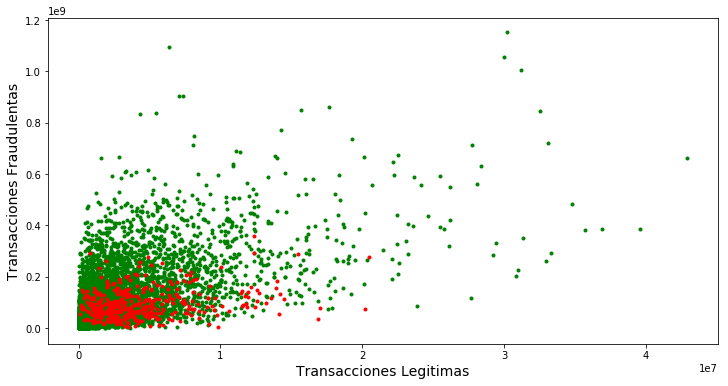

In [22]:
# Representación gráfica de dos características
plt.figure(figsize=(12, 6))
plt.scatter(df["ANTICIPOS_CTE"][df['OBJETIVO'] == 'Aceptado'], df["TOTAL_VENTAS"][df['OBJETIVO'] == 'Aceptado'], c="g", marker=".")
plt.scatter(df["ANTICIPOS_CTE"][df['OBJETIVO'] == 'Sospechoso'], df["TOTAL_VENTAS"][df['OBJETIVO'] == 'Sospechoso'], c="r", marker=".")
plt.xlabel("Transacciones Legitimas", fontsize=14)
plt.ylabel("Transacciones Fraudulentas", fontsize=14)
plt.show()

## Generacion de modelos con las mejores caractersiticas

#### Transformación 1: excluir columnas no relevantes del conjunto de datos

In [23]:
df5 =  DropColumns(columns=columnas_eliminar).fit_transform(X=df)

#### Transformación 2: tratamiento de datos faltantes

In [24]:
df6 = DataFrameImputer().fit_transform(df5)

#### Transformación 3: Escalamiento de los datos

In [25]:
df7 = DataScaleImputer(columns=['OBJETIVO']).fit_transform(df6)

In [26]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9400 entries, 0 to 9399
Data columns (total 11 columns):
EFECTIVO                     9400 non-null float64
INVENTARIO                   9400 non-null float64
TERRENOS_Y_CONSTRUCCIONES    9400 non-null float64
CXP                          9400 non-null float64
ANTICIPOS_CTE                9400 non-null float64
UTILIDADES_ACUMULADAS        9400 non-null float64
UTILIDAD_O_PERDIDA           9400 non-null float64
TOTAL_VENTAS                 9400 non-null float64
UTILIDAD_BRUTA               9400 non-null float64
TOTAL_GASTOS                 9400 non-null float64
OBJETIVO                     9400 non-null object
dtypes: float64(10), object(1)
memory usage: 807.9+ KB


#### Definición de features (Variables Independientes)

En este * ejemplo * usaremos todas las columnas. (Usted debe decidir cuales variables utilizar)

In [27]:
features = df7[    
        columnas_modelo    
]
target = df7["OBJETIVO"] 

## Balanceo de datos

In [28]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

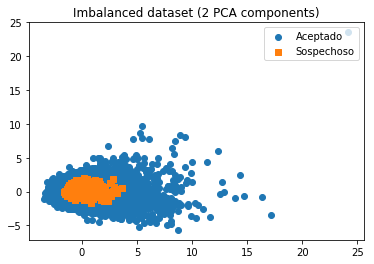

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)

plot_2d_space(X_pca, target, 'Imbalanced dataset (2 PCA components)')

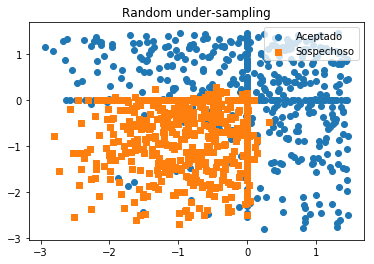

In [30]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='auto')
X_rus, y_rus = rus.fit_sample(features, target)
plot_2d_space(X_rus.values, y_rus, 'Random under-sampling')

#### División en 80% entrenamiento y 20% pruebas

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.2, random_state=None)

#### Crea Modelo de Ensamble -  Entrenando varios modelos de clasificación previo tunnig ver sección final

Los parametros optimizados son:
 {'RNN__solver': 'adam', 'RNN__max_iter': 1620, 'RNN__learning_rate': 'constant', 'RNN__hidden_layer_sizes': (20, 100, 2), 'RNN__alpha': 0.0001, 'RNN__activation': 'logistic', 'RFOR__n_estimators': 600, 'RFOR__min_samples_split': 2, 'RFOR__min_samples_leaf': 1, 'RFOR__max_features': 'sqrt', 'RFOR__max_depth': 30, 'RFOR__bootstrap': False, 'ABO__n_estimators': 1645, 'ABO__learning_rate': 0.1, 'ABO__algorithm': 'SAMME.R'}

In [32]:
class_RFO = RandomForestClassifier(n_estimators=600, min_samples_split= 2, min_samples_leaf=1, max_features= 'sqrt', max_depth= 30, bootstrap=False, random_state=semilla_aleatoria)
class_RNN = MLPClassifier(solver='adam',max_iter=1620, learning_rate='constant', hidden_layer_sizes=(20, 100, 2), alpha=0.0001, activation='logistic', random_state=semilla_aleatoria)
class_ABO = AdaBoostClassifier(n_estimators= 1645, learning_rate= 0.1, algorithm= 'SAMME.R',random_state=semilla_aleatoria)

dtc_model = VotingClassifier(estimators=[('RFOR', class_RFO),('RNN',class_RNN),('ABO', class_ABO)], voting='hard')
dtc_model.fit(X_train, y_train)

VotingClassifier(estimators=[('RFOR',
                              RandomForestClassifier(bootstrap=False,
                                                     max_depth=30,
                                                     max_features='sqrt',
                                                     n_estimators=600,
                                                     random_state=1234)),
                             ('RNN',
                              MLPClassifier(activation='logistic',
                                            hidden_layer_sizes=(20, 100, 2),
                                            max_iter=1620, random_state=1234)),
                             ('ABO',
                              AdaBoostClassifier(learning_rate=0.1,
                                                 n_estimators=1645,
                                                 random_state=1234))])

#### Haciendo una predicción con el set de prueba

In [33]:
y_pred = dtc_model.predict(X_test)
print(y_pred)

['Aceptado' 'Aceptado' 'Sospechoso' 'Sospechoso' 'Sospechoso' 'Sospechoso'
 'Sospechoso' 'Sospechoso' 'Aceptado' 'Aceptado' 'Aceptado' 'Aceptado'
 'Aceptado' 'Aceptado' 'Sospechoso' 'Aceptado' 'Sospechoso' 'Aceptado'
 'Aceptado' 'Aceptado' 'Sospechoso' 'Aceptado' 'Aceptado' 'Sospechoso'
 'Sospechoso' 'Sospechoso' 'Aceptado' 'Aceptado' 'Aceptado' 'Sospechoso'
 'Aceptado' 'Aceptado' 'Sospechoso' 'Aceptado' 'Aceptado' 'Sospechoso'
 'Aceptado' 'Sospechoso' 'Sospechoso' 'Sospechoso' 'Aceptado' 'Sospechoso'
 'Sospechoso' 'Aceptado' 'Aceptado' 'Sospechoso' 'Aceptado' 'Aceptado'
 'Aceptado' 'Sospechoso' 'Sospechoso' 'Aceptado' 'Sospechoso' 'Sospechoso'
 'Aceptado' 'Sospechoso' 'Aceptado' 'Sospechoso' 'Aceptado' 'Sospechoso'
 'Aceptado' 'Sospechoso' 'Sospechoso' 'Aceptado' 'Sospechoso' 'Sospechoso'
 'Sospechoso' 'Aceptado' 'Sospechoso' 'Sospechoso' 'Sospechoso' 'Aceptado'
 'Sospechoso' 'Sospechoso' 'Aceptado' 'Aceptado' 'Sospechoso' 'Aceptado'
 'Sospechoso' 'Sospechoso' 'Aceptado' 'Aceptado' 'S

### Matriz de confusion

In [34]:
display(confusion_matrix(y_test,y_pred))
class_report=classification_report(y_test,y_pred)
print(class_report) 

array([[102,   9],
       [  5,  95]])

              precision    recall  f1-score   support

    Aceptado       0.95      0.92      0.94       111
  Sospechoso       0.91      0.95      0.93       100

    accuracy                           0.93       211
   macro avg       0.93      0.93      0.93       211
weighted avg       0.93      0.93      0.93       211



#### Analizar la calidad del modelo a través de la matriz de confusión

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.934\nPrecision=0.913\nRecall=0.950\nF1 Score=0.9313725490196078')

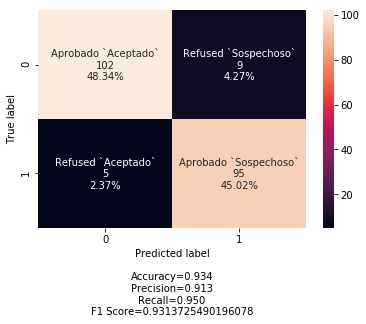

In [35]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

### Validacion Cruzada Kfolds

In [36]:
def graficar_accuracy_scores(estimator, train_x, train_y,test_x,test_y,nparts=5,jobs=None):
    kfold = KFold(n_splits=nparts,shuffle=True, random_state=semilla_aleatoria)
    fig,axes = plt.subplots(figsize=(7, 3))
    axes.set_title("Ratio de éxito(Accuracy)/Nro. Fold")
    axes.set_xlabel("Nro. Fold")
    axes.set_ylabel("Accuracy")    
    train_scores = cross_val_score(estimator, train_x,train_y, cv = kfold, n_jobs=jobs, scoring="accuracy")
    test_scores = cross_val_score(estimator, test_x, test_y, cv = kfold, n_jobs=jobs, scoring="accuracy")        
    train_sizes = range(1,nparts+1,1)    
    axes.grid()    
    axes.plot(train_sizes, train_scores, 'o-', color="r",label="Datos Entrenamiento")
    axes.plot(train_sizes, test_scores, 'o-', color="g",label="Validacion Cruzada")
    axes.legend(loc="best")
    return train_scores

array([0.91715976, 0.92899408, 0.90532544, 0.95238095, 0.95238095])

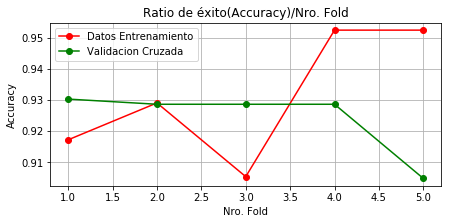

In [37]:
graficar_accuracy_scores(dtc_model,X_train,y_train,X_test,y_test,nparts=5,jobs=2)

### Tunning de los Hiperparametros de los Modelos
Correr únicamente si se desea hacer una mejora en los hiper parametros

#### Cambiar esta celda a CODE
parameter_space = {
    'RFOR__n_estimators':  [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'RFOR__max_features': ['auto', 'sqrt'],
    'RFOR__max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'RFOR__min_samples_split': [2, 5, 10],
    'RFOR__min_samples_leaf':  [1, 2, 4],
    'RFOR__bootstrap': [True, False],        
    'RNN__hidden_layer_sizes': [(10,40,2),(20,100,4),(20,100,2),(100,100,8),(10,200,4)],
    'RNN__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'RNN__solver': ['sgd', 'adam'],
    'RNN__alpha': [0.0001, 0.05, 0.02, 0.1],
    'RNN__max_iter': [int(x) for x in np.linspace(start = 100, stop = 2000, num = 6)],              
    'RNN__learning_rate': ['constant','adaptive'],
    'ABO__n_estimators':  [int(x) for x in np.linspace(start = 50, stop = 2000, num = 12)],
    'ABO__learning_rate': [1.0, 0.1, 0.01, 0.001],
    'ABO__algorithm': ['SAMME', 'SAMME.R']
}

clf_CV = RandomizedSearchCV(dtc_model, parameter_space, n_jobs=-1, cv=5)
clf_CV.fit(X_train, y_train) 
print('Los parametros optimizados son:\n', clf_CV.best_params_)

##### ¡ATENCIÓN! Su puntuación en este desafío de clasificación se basará en la puntuación F1 del modelo al predecir el dataset de evaluación.

<hr>

## Puntuación de los datos necesarios para entregar la solución

Como entrega de su solución, esperamos que los resultados se clasifiquen en el siguiente conjunto de datos llamado "to_be_scored_compusoluciones.csv":

### Descarga la "hoja de evaluación"

In [38]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset/master/to_be_scored_compusoluciones.csv
df_to_be_scored = pd.read_csv(r'to_be_scored_compusoluciones.csv')
df_to_be_scored.tail()

--2020-09-04 15:52:16--  https://raw.githubusercontent.com/vanderlei-test/dataset/master/to_be_scored_compusoluciones.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100124 (98K) [text/plain]
Saving to: ‘to_be_scored_compusoluciones.csv.1’

100%[======================================>] 100,124     --.-K/s   in 0.005s  

2020-09-04 15:52:16 (19.4 MB/s) - ‘to_be_scored_compusoluciones.csv.1’ saved [100124/100124]



,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS
595,3.893725e+06,5.279410e+06,9.811669e+02,1.757291e+07,3.989011e+06,-1.545727e+07,2.497177e+06,103003.8264,2402813.337,NaN,1.751228e+07,-4050340.635,8.830412e+07,1.147548e+08,NaN,1.858752e+06
596,8.806031e+05,3.354813e+07,NaN,5.241604e+06,NaN,-1.727618e+06,4.021914e+07,821297.6732,3154291.078,NaN,1.636395e+07,-2394015.114,1.257229e+08,7.169861e+07,2.675382e+07,2.455403e+07
597,NaN,2.711050e+07,3.260820e+06,4.681080e+06,NaN,-3.291876e+06,3.763157e+07,NaN,1861471.266,942635.7885,7.126997e+06,NaN,6.531900e+07,1.014415e+08,2.333685e+07,NaN
598,7.443979e+06,4.076322e+07,6.408235e+06,1.507174e+07,6.257927e+05,-7.237902e+06,6.080636e+07,NaN,5220998.681,NaN,9.928204e+06,-3351032.988,9.340985e+07,1.571700e+08,3.062958e+07,3.042192e+07
599,5.611681e+05,6.438914e+06,3.867058e+06,4.545890e+05,1.949220e+06,-3.280783e+06,NaN,427294.9401,3954071.593,532328.4053,1.823676e+07,-5664180.434,1.059266e+08,5.820347e+07,5.238135e+05,2.470879e+06


# ¡Atención!

El Dataframe ``to_be_scored_compusoluciones`` es su "hoja de evaluación". Tenga en cuenta que a la columna "OBJETIVO" le faltan datos en este ejemplo, que luego no se pueden usar para entrenar modelos de aprendizaje supervisado.

In [39]:
df_to_be_scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 16 columns):
EFECTIVO                     511 non-null float64
CXC                          511 non-null float64
INVENTARIO                   511 non-null float64
EQ_OFICINA                   505 non-null float64
EQ_TRANSPORTE                513 non-null float64
TERRENOS_Y_CONSTRUCCIONES    513 non-null float64
CXP                          523 non-null float64
CONTRIBUCIONES_X_PAGAR       499 non-null float64
ANTICIPOS_CTE                515 non-null float64
CAP_SOCIAL                   504 non-null float64
UTILIDADES_ACUMULADAS        496 non-null float64
UTILIDAD_O_PERDIDA           514 non-null float64
TOTAL_VENTAS                 506 non-null float64
TOTAL_COMPRAS                527 non-null float64
UTILIDAD_BRUTA               501 non-null float64
TOTAL_GASTOS                 510 non-null float64
dtypes: float64(16)
memory usage: 75.1 KB


<hr>

# ¡Atención!

# Para aplicar su modelo y clasificar la hoja de evaluación, primero debe aplicar las mismas transformaciones de columnas que aplicó al conjunto de datos de entrenamiento.

# No elimine ni agregue líneas a la hoja de respuestas.

# No cambie el orden de las líneas en la hoja de respuestas.

# Al final, se deben clasificar las 600 entradas, con los valores calculados en la columna "target"

<hr>

En la celda de abajo, repetimos rápidamente los mismos pasos de preprocesamiento usados ​​en el ejemplo dado con el árbol de decisiones

In [40]:
# Aplicar la transformaciones al conjunto de datos base
df_to_be_scored_2 = DropColumns(columns=columnas_eliminar).fit_transform(X=df_to_be_scored)
df_to_be_scored_3 = DataFrameImputer().fit_transform(df_to_be_scored_2)
df_to_be_scored_4 = DataScaleImputer(columns=[]).fit_transform(df_to_be_scored_3)

In [41]:
# Realización de una prueba a ciegas en el modelo creado
y_pred = dtc_model.predict(df_to_be_scored_4)

In [42]:
# Agregando las respuestas en la columna "target"
df_to_be_scored_4['target'] = y_pred
df_to_be_scored_4.tail()

,EFECTIVO,INVENTARIO,TERRENOS_Y_CONSTRUCCIONES,CXP,ANTICIPOS_CTE,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,UTILIDAD_BRUTA,TOTAL_GASTOS,target
595,6.758164e-01,-7.100464e-01,-2.576841,-9.191551e-01,-0.367380,0.980768,-3.843551e-01,-0.197391,2.417381e-16,-1.094235e+00,Aceptado
596,-2.715010e-01,-1.431923e-16,0.004557,7.024546e-01,-0.146327,0.847805,4.065439e-01,0.200682,7.553713e-01,8.233499e-01,Aceptado
597,1.464027e-16,-4.594437e-01,-0.289549,5.912189e-01,-0.526620,-0.221730,-6.670627e-16,-0.441914,5.336400e-01,-4.721397e-16,Aceptado
598,1.792007e+00,-2.174838e-01,-1.031466,1.587468e+00,0.461611,0.102618,-5.043419e-02,-0.143075,1.006873e+00,1.319144e+00,Aceptado
599,-3.719305e-01,-4.128387e-01,-0.287464,3.202891e-16,0.088934,1.064655,-1.154967e+00,-0.009917,-9.467221e-01,-1.042515e+00,Aceptado


### Guardar la hoja de respuestas como un archivo .csv para enviar
**SI YA TIENE UN DATA ASSET CON EL NOMBRE `results.csv` EN ESTE PROYECTO O EN OTRO PROYECTO DE WATSON STUDIO DEBE BORRAR EL ARCHIVO ANTES DE CORRER LA SIGUIENTE CELDA O TENDRA EL ERROR: _RuntimeError: File 'results.csv' already exists in storage._**

In [43]:
project.save_data(file_name="results.csv", data=df_to_be_scored_4.to_csv(index=False))

{'file_name': 'results.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'btccompusoluciones-donotdelete-pr-rwejqewrky9ng9',
 'asset_id': '8528c955-ca9a-4ba3-bd7e-5d82bcd99ae8'}

# Atención

# La ejecución de la celda anterior creará un nuevo "data asset" en su proyecto de Watson Studio. Deberá descargar este archivo junto con este cuaderno y crear un archivo zip con **results.csv** y **notebook.ipynb** para enviarlo. (los archivos deben tener este nombre)

<hr>

## ¡Felicitaciones! 

Si ya está satisfecho con su solución, vaya a la página siguiente y envíe los archivos necesarios para su envío.

# https://compusoluciones.maratona.dev